There are two axes of neural network uncertainty that can be modeled: 
- uncertainty in the data, called aleatoric uncertainty. This could be for example sensor noise or motion noise, resulting in uncertainty which cannot be reduced even if more data were to be collected. 
- uncertainty in the prediction, called epistemic uncertainty. It can be explained away given enough data, and is often referred to as model uncertainty.

In this notebook we will train models which can predict both types of uncertainty. We will see that model exhibits
- increased aleatoric uncertainty on object boundaries and for objects far from the camera
- increased epistemic uncertainty for semantically and visually challenging pixels.

However modeling only one of them comes at a cost. Out-of-data examples, which can be identified with epistemic uncertainty, cannot be identified with aleatoric uncertainty alone and vice versa.
We will see a failure case of the regression model when the model fails due to increased epistemic uncertainty, but not aleatoric uncertainty.
Thus we will combine both of the uncertainties to leverage their strength. 

In [2]:
import sys
sys.path.append('..')

In [3]:
import tensorflow as tf

import configs.demo as config
from models import unet
from wrap import AleatoricWrapper, EpistemicWrapper
from utils import get_datasets, visualize_depth_map, notebook_select_gpu, \
    load_model, select_best_checkpoint, gen_ood_comparison

from run_utils import setup
path, checkpoints_path, vis_path, plots_path, logs_path = setup('demo')
notebook_select_gpu(1)

In [4]:
ds_train, ds_test, ds_ood = get_datasets()

### Base

In [10]:
user_model = unet(compile=True)

In [ ]:
# x, y = iter(ds_train).get_next()
# y_hat = user_model(x)
visualize_depth_map(user_model, ds_train, vis_path, f'base_random_train', is_show=True, plot_uncertainty=False)

##### Train

In [6]:
# model_name = 'demo-base'
# history = user_model.fit(ds_train, epochs=config.EP,
#     validation_data=ds_test,
# )

##### Load trained model

In [11]:
path, model_name = select_best_checkpoint(config.BASE_PATH)
trained_user_model = load_model(path, model_name, ds_train)

2022-08-30 04:24:30.090847: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /data/capsa/depth/results/base/20220829-135832/checkpoints/0.003vloss_17204iter.tf: FAILED_PRECONDITION: /data/capsa/depth/results/base/20220829-135832/checkpoints/0.003vloss_17204iter.tf; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


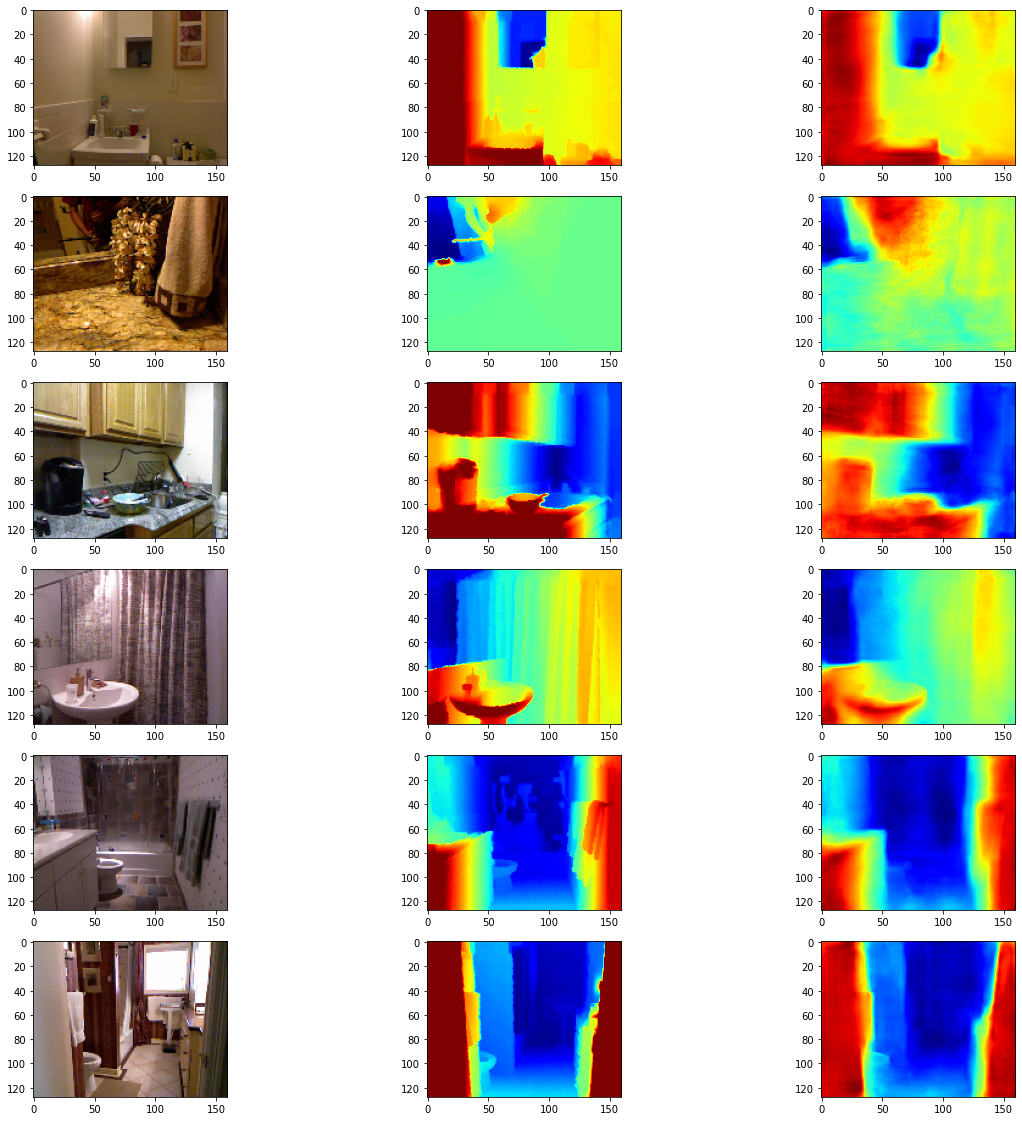

In [12]:
visualize_depth_map(trained_user_model, ds_train, vis_path, f'train', is_show=True, plot_uncertainty=False)
# visualize_depth_map(trained_user_model, ds_test, vis_path, f'test', is_show=True, plot_uncertainty=False)
# visualize_depth_map(trained_user_model, ds_ood, vis_path, 'ood', is_show=True, plot_uncertainty=False)

### Aleatoric

##### Train

In [ ]:
user_model = unet()
aleatoric_model = AleatoricWrapper(user_model)

model_name = 'demo-aleatoric'
history = aleatoric_model.fit(ds_train, epochs=config.EP,
    validation_data=ds_test,
)

In [ ]:
visualize_depth_map(aleatoric_model, ds_train, vis_path, 'train', is_show=True)
# visualize_depth_map(aleatoric_model, ds_test, vis_path, 'test', is_show=True)
# visualize_depth_map(aleatoric_model, ds_ood, vis_path, 'ood', is_show=True)

##### Load trained model

In [9]:
path, model_name = select_best_checkpoint(config.ALEATORIC_PATH)
trained_aleatoric = load_model(path, model_name, ds_train)

Successfully loaded weights from /data/capsa/depth/results/mve/20220827-211807/checkpoints/-2.262vloss_51300iter.tf.


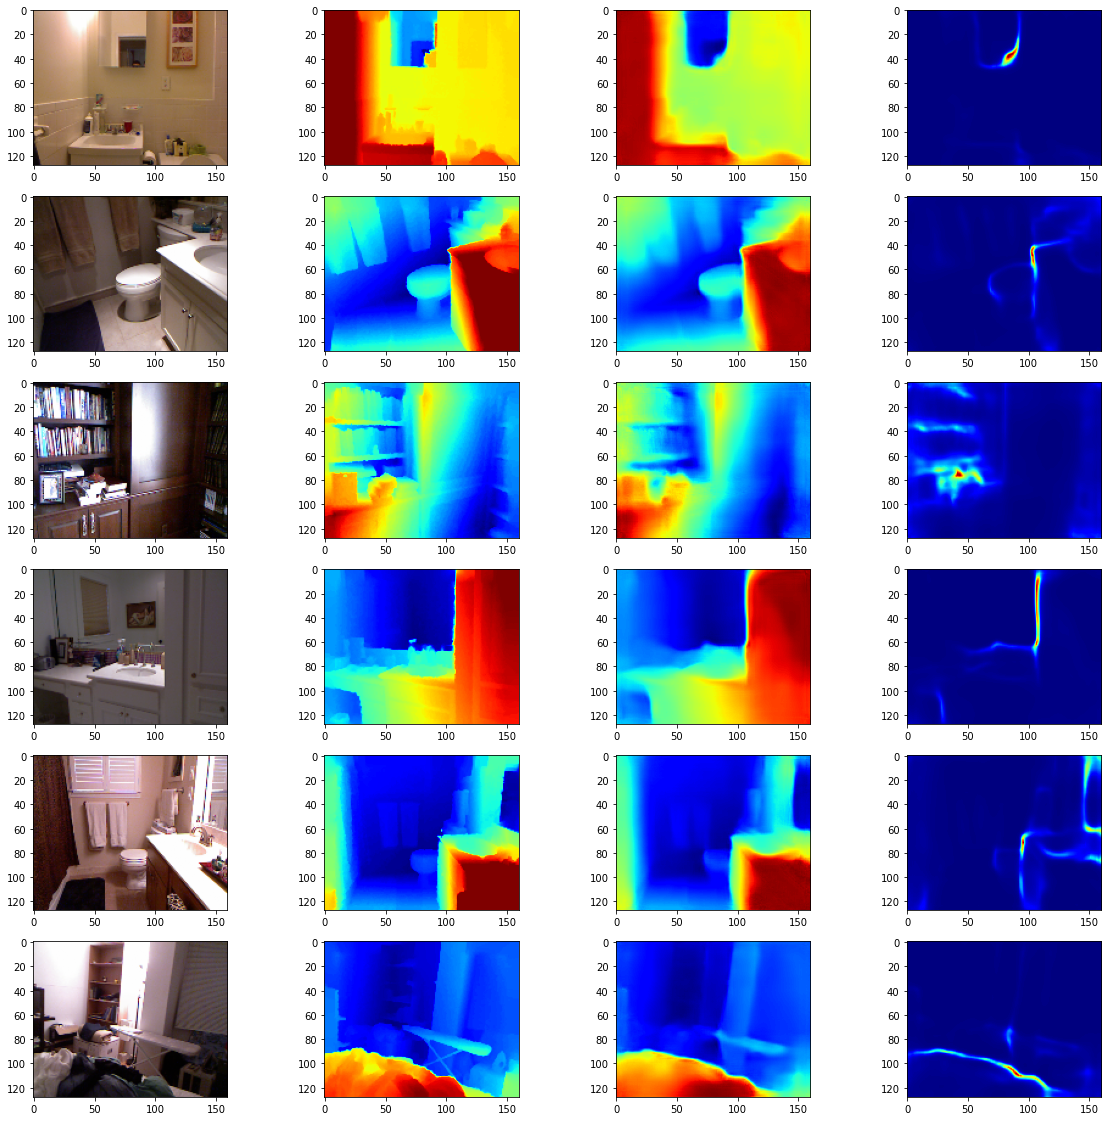

In [11]:
visualize_depth_map(trained_aleatoric, ds_train, vis_path, f'trained_train', is_show=True)
# visualize_depth_map(trained_aleatoric, ds_test, vis_path, f'trained_test', is_show=True)
# visualize_depth_map(trained_aleatoric, ds_ood, vis_path, f'trained_ood', is_show=True)

### Epistemic

##### Train

In [ ]:
user_model = unet()
epistemic_model = EpistemicWrapper(user_model)

model_name = 'demo-epistemic'
history = epistemic_model.fit(ds_train, epochs=config.EP,
    validation_data=ds_test,
)

In [ ]:
visualize_depth_map(epistemic_model, ds_train, vis_path, 'train', is_show=True)
# visualize_depth_map(epistemic_model, ds_test, vis_path, 'test', is_show=True)
# visualize_depth_map(epistemic_model, ds_ood, vis_path, 'ood', is_show=True)

##### Load trained model

In [ ]:
path, model_name = select_best_checkpoint(config.EPISTEMIC_PATH)
trained_epistemic = load_model(path, model_name, ds_train)

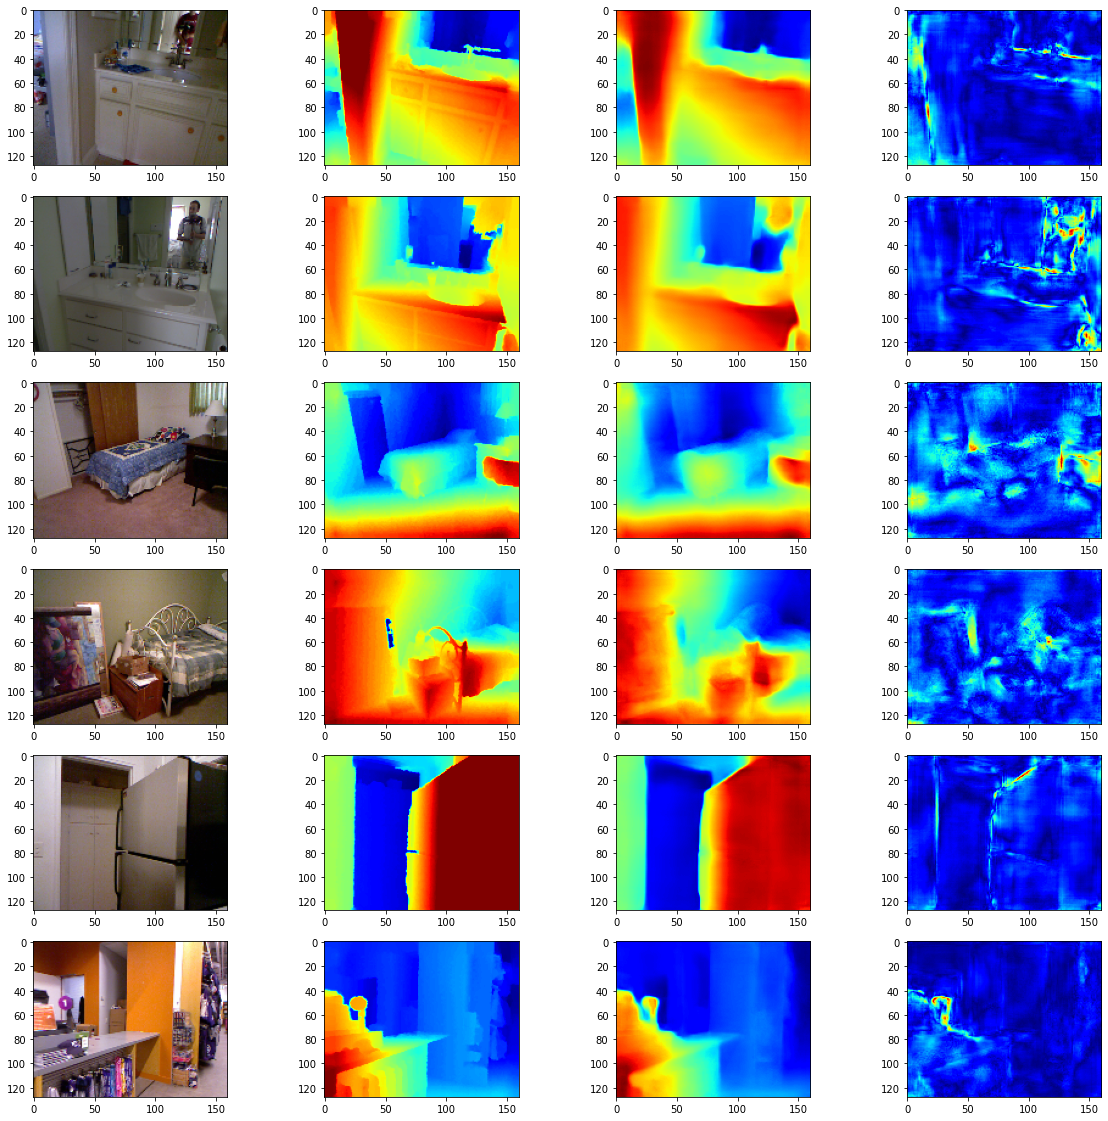

In [5]:
visualize_depth_map(trained_epistemic, ds_train, vis_path, f'trained_train', is_show=True)
# visualize_depth_map(trained_epistemic, ds_test, vis_path, f'trained_test', is_show=True)
# visualize_depth_map(trained_epistemic, ds_ood, vis_path, f'trained_ood', is_show=True)

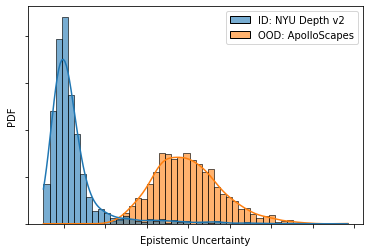

In [12]:
gen_ood_comparison(ds_test, ds_ood, model=trained_epistemic)